C:\Users\manur\AppData\Local\Temp\ipykernel_26488\3789374293.py:105: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_26488\3789374293.py:105: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_26488\3789374293.py:105: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_26488\3789374293.py:105: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_26488\3789374293.py:105: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_26488\3789374293.py:105: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_26488\3789374293.py:105: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_26488\3789374293.py:105: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_26488\3789374293.py:105: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipy

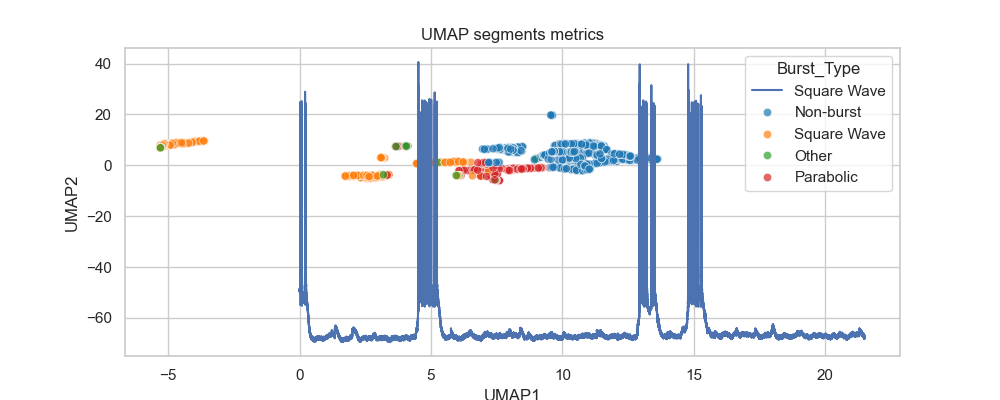

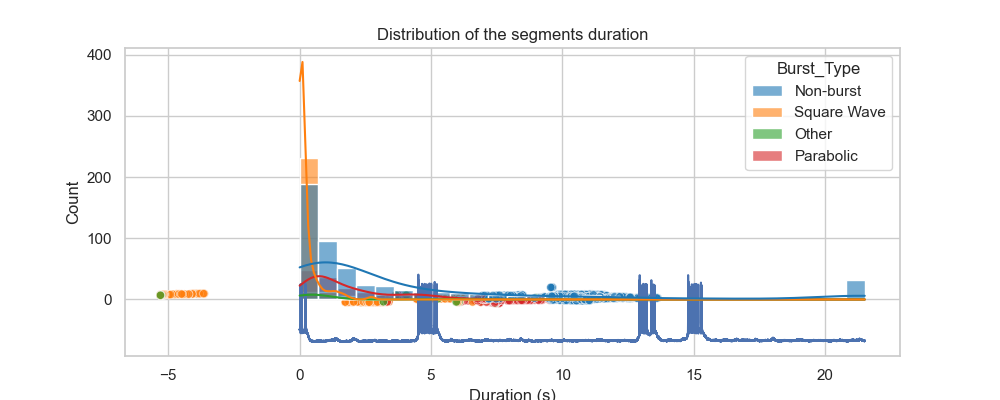

In [14]:
#Load libraries
import os
import pyabf
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks, hilbert
from numpy.linalg import lstsq
from sklearn.metrics import r2_score
%matplotlib widget

#Dimensionality reduction & ML
import umap
from sklearn.preprocessing import StandardScaler

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "browser"

#Parameters
folder_path = "bursting"   # Folder with ABF files
threshold = -35            # Spike detection threshold (mV)
burst_threshold = 0.3      # Max ISI for burst (s)
fs = 10000                 # Sampling frequency (Hz)
dt = 1 / fs

# Criteria
min_spikes_in_burst = 4    # At least 4 spikes to define a burst (best option is between a range from 3-6), being 4 the best option
max_isi = 0.3              # Max ISI allowed inside burst
min_spike_rate = 5         # Minimum spike rate (Hz)

all_segment_metrics = []

#ABF files
abf_files = [f for f in os.listdir(folder_path) if f.endswith(".abf")]

for file_name in abf_files:
    file_path = os.path.join(folder_path, file_name)
    abf = pyabf.ABF(file_path)

    for sweep in range(abf.sweepCount):
        abf.setSweep(sweep)
        time = abf.sweepX
        voltage = abf.sweepY

        #Spike detection
        peaks, _ = find_peaks(voltage, height=threshold)
        spike_times = peaks / fs

        #Burst detection
        bursts = []
        if len(spike_times) >= min_spikes_in_burst:
            isi = np.diff(spike_times)
            current_burst = [spike_times[0]]

            for i in range(1, len(spike_times)):
                if isi[i-1] < burst_threshold:
                    current_burst.append(spike_times[i])
                else:
                    if len(current_burst) >= min_spikes_in_burst:
                        bursts.append((current_burst[0], current_burst[-1]))
                    current_burst = [spike_times[i]]
            if len(current_burst) >= min_spikes_in_burst:
                bursts.append((current_burst[0], current_burst[-1]))

        #Segments (bursts + non-bursts)
        segments = []
        for start, end in bursts:
            segments.append((start, end, "Burst"))

        if bursts:
            if bursts[0][0] > time[0]:
                segments.insert(0, (time[0], bursts[0][0], "Non-burst"))
            for i in range(len(bursts)-1):
                segments.append((bursts[i][1], bursts[i+1][0], "Non-burst"))
            if bursts[-1][1] < time[-1]:
                segments.append((bursts[-1][1], time[-1], "Non-burst"))
        else:
            segments.append((time[0], time[-1], "Non-burst"))

        #Classify bursts
        burst_types = []
        for i, (seg_start, seg_end, seg_type) in enumerate(segments):
            if seg_type == "Burst":
                seg_mask = (time >= seg_start) & (time <= seg_end)
                seg_voltage = voltage[seg_mask]
                seg_time = time[seg_mask]

                #Compute baseline before/after
                prev_mean = np.nan
                next_mean = np.nan
                if i > 0:
                    prev_end = segments[i-1][1]
                    inter_mask_prev = (time > prev_end) & (time < seg_start)
                    if np.any(inter_mask_prev):
                        prev_mean = np.mean(voltage[inter_mask_prev])
                if i < len(segments)-1:
                    next_start = segments[i+1][0]
                    inter_mask_next = (time > seg_end) & (time < next_start)
                    if np.any(inter_mask_next):
                        next_mean = np.mean(voltage[inter_mask_next])
                inter_mean = np.nanmean([prev_mean, next_mean])

                burst_min = np.min(seg_voltage)

                #Parabolic fit
                t = np.linspace(-0.5, 0.5, len(seg_voltage))
                X = np.vstack([t**2, t, np.ones_like(t)]).T
                coef, *_ = lstsq(X, seg_voltage, rcond=None)
                y_hat = X @ coef
                r2_parabola = r2_score(seg_voltage, y_hat)

                #Symmetry from Hilbert envelope
                analytic_signal = hilbert(seg_voltage)
                envelope = np.abs(analytic_signal)
                half = len(envelope) // 2
                symmetry = (np.corrcoef(envelope[:half], envelope[-half:][::-1])[0, 1]
                            if half >= 2 else np.nan)

                #Spike metrics
                seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
                spike_rate = len(seg_peaks) / (seg_end - seg_start)

                #Classification
                if np.isnan(inter_mean):
                    burst_type = "Other"
                elif burst_min > inter_mean:
                    burst_type = "Square Wave"
                elif burst_min < inter_mean:
                    burst_type = "Parabolic"
                else:
                    burst_type = "Other"
            else:
                burst_type = "Non-burst"

            burst_types.append(burst_type)

        #Compute metrics for each segment
        for j, (seg_start, seg_end, seg_type) in enumerate(segments):
            seg_mask = (time >= seg_start) & (time <= seg_end)
            seg_voltage = voltage[seg_mask]
            duration = seg_end - seg_start
            burst_type = burst_types[j]

            seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
            num_peaks = len(seg_peaks)
            mean_isi = np.mean(np.diff(seg_peaks / fs)) if num_peaks >= 2 else 0

            if len(seg_voltage) < 2:
                mean_val = std_val = min_val = max_val = skew_val = kurt_val = area_val = 0
            else:
                mean_val = np.mean(seg_voltage)
                std_val = np.std(seg_voltage)
                min_val = np.min(seg_voltage)
                max_val = np.max(seg_voltage)
                skew_val = skew(seg_voltage)
                kurt_val = kurtosis(seg_voltage)
                area_val = np.trapezoid(seg_voltage, dx=dt)

            if len(seg_voltage) < 2:
                mean_d = std_d = min_d = max_d = skew_d = kurt_d = 0
            else:
                deriv = np.diff(seg_voltage) / dt
                mean_d = np.mean(deriv)
                std_d = np.std(deriv)
                min_d = np.min(deriv)
                max_d = np.max(deriv)
                skew_d = skew(deriv)
                kurt_d = kurtosis(deriv)

            all_segment_metrics.append([
                file_name, sweep, seg_type, burst_type, duration,
                num_peaks, mean_isi,
                mean_val, std_val, min_val, max_val, skew_val, kurt_val, area_val,
                mean_d, std_d, min_d, max_d, skew_d, kurt_d
            ])

#Save results
df_segments = pd.DataFrame(all_segment_metrics, columns=[
    "File_Name", "Sweep", "Segment_Type", "Burst_Type", "Duration",
    "Num_Peaks", "Mean_ISI",
    "Mean", "Std", "Min", "Max", "Skewness", "Kurtosis", "Area",
    "Mean_Deriv", "Std_Deriv", "Min_Deriv", "Max_Deriv", "Skewness_Deriv", "Kurtosis_Deriv"
])
df_segments.to_csv("segment_voltage_metrics_with_ISI_and_peaks.csv", index=False)

#Visualization: UMAP & Distributions
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
df = pd.read_csv("segment_voltage_metrics_with_ISI_and_peaks.csv")
header = list(df)[4:]
X = np.array(df[header])
y = np.array(df.Burst_Type)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

df_umap = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
df_umap["Burst_Type"] = y

sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue="Burst_Type", palette="tab10", alpha=0.7)
plt.title("UMAP segments metrics")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

sns.set(style="whitegrid", context="notebook", rc={'figure.figsize':(10,6)})
sns.histplot(data=df_segments, x="Duration", hue="Burst_Type",
             bins=30, kde=True, palette="tab10", alpha=0.6)
plt.title("Distribution of the segments duration")
plt.xlabel("Duration (s)")
plt.ylabel("Count")
plt.show()

fig = px.scatter(df_umap, x="UMAP1", y="UMAP2", color="Burst_Type", title="UMAP")
pio.renderers.default = "browser"
fig.show()



Distancia entre centroides de tipos de bursts:
Burst_Type   Non-burst     Other  Parabolic  Square Wave
Burst_Type                                              
Non-burst     0.000000  6.982493   6.356981     9.964681
Other         6.982493  0.000000   5.053357     2.984769
Parabolic     6.356981  5.053357   0.000000     7.086916
Square Wave   9.964681  2.984769   7.086916     0.000000

Umbral de solapamiento (distancia UMAP): 3.192

Pares de tipos de bursts potencialmente solapados:
[('Other', 'Square Wave')]

Número de segmentos en regiones de conflicto: 147
Burst_Type
Non-burst      17
Other          21
Parabolic      73
Square Wave    36
dtype: int64


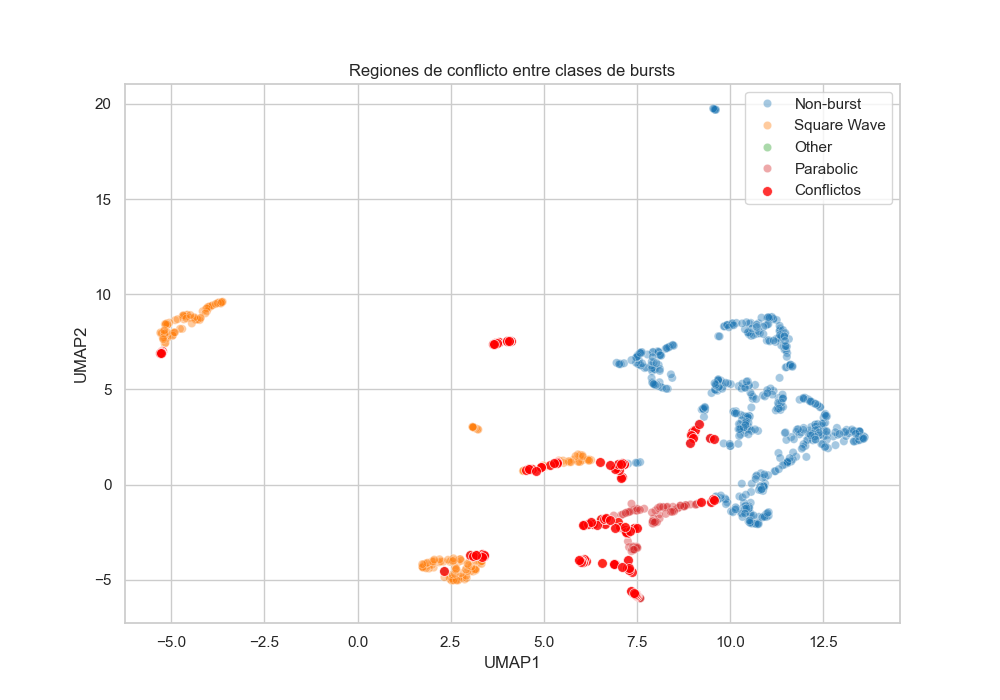

In [15]:
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors

# Añadimos índices para relacionar cada fila con df_segments original
df_umap["Index"] = df.index  # Para poder buscar las series temporales luego

# ---- 1. Calcular centroides por tipo de burst ----
centroids = df_umap.groupby("Burst_Type")[["UMAP1", "UMAP2"]].mean()

# ---- 2. Matriz de distancias entre centroides ----
dist_matrix = distance.cdist(centroids.values, centroids.values)
dist_df = pd.DataFrame(dist_matrix, index=centroids.index, columns=centroids.index)

print("\nDistancia entre centroides de tipos de bursts:")
print(dist_df)

# Definir un umbral de solapamiento relativo (puedes ajustar)
threshold = np.percentile(dist_matrix[dist_matrix > 0], 10)  # 10% de distancias más cortas
print(f"\nUmbral de solapamiento (distancia UMAP): {threshold:.3f}")

# Encontrar pares de tipos de bursts muy cercanos
close_pairs = []
for i, type_i in enumerate(centroids.index):
    for j, type_j in enumerate(centroids.index):
        if j > i and dist_matrix[i, j] < threshold:
            close_pairs.append((type_i, type_j))

print("\nPares de tipos de bursts potencialmente solapados:")
print(close_pairs)

# ---- 3. Puntos individuales que están mezclados ----
X_umap = df_umap[["UMAP1", "UMAP2"]].values
labels = df_umap["Burst_Type"].values

nbrs = NearestNeighbors(n_neighbors=8).fit(X_umap)
distances, indices = nbrs.kneighbors(X_umap)

conflict_indices = []
for i, neighbors in enumerate(indices):
    own_type = labels[i]
    neighbor_types = labels[neighbors]
    if np.any(neighbor_types != own_type):  # vecinos de otra clase
        conflict_indices.append(df_umap.iloc[i]["Index"])

conflicts_df = df_segments.iloc[conflict_indices]

print(f"\nNúmero de segmentos en regiones de conflicto: {len(conflicts_df)}")
print(conflicts_df.groupby("Burst_Type").size())

# ---- 4. Graficar puntos en conflicto ----
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue="Burst_Type", alpha=0.4, palette="tab10")
sns.scatterplot(data=df_umap.iloc[conflict_indices], x="UMAP1", y="UMAP2", 
                color="red", s=50, label="Conflictos", alpha=0.8)
plt.legend()
plt.title("Regiones de conflicto entre clases de bursts")
plt.show()

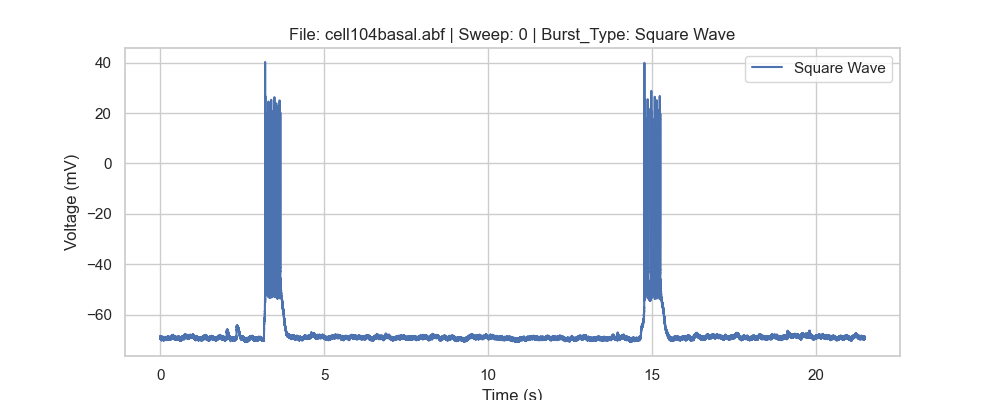

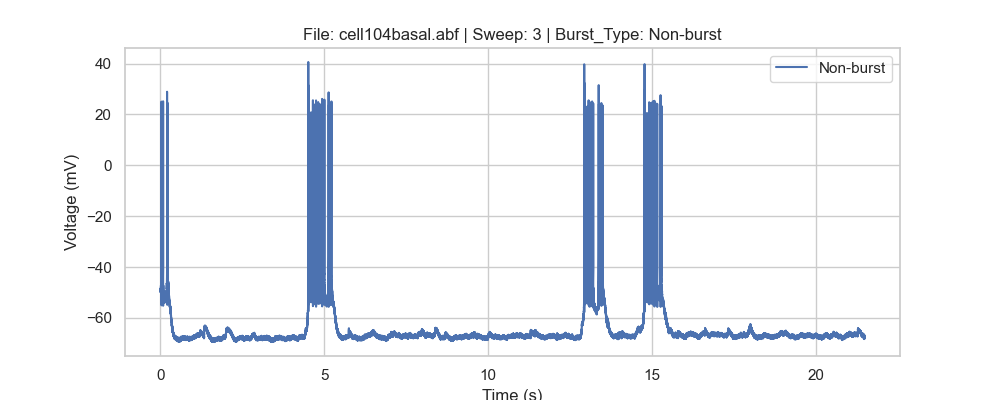

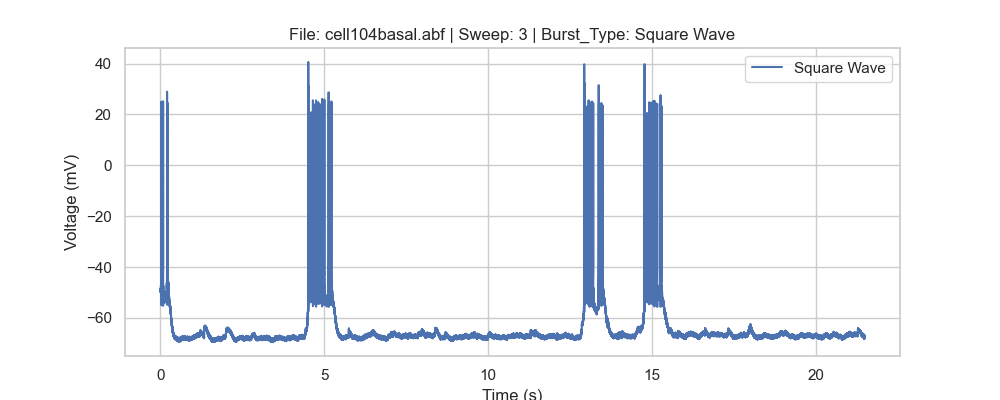

In [16]:
# Ejemplo: comparar los primeros 3 pares conflictivos
for idx in conflicts_df.head(3).index:
    row = conflicts_df.loc[idx]
    file_path = os.path.join(folder_path, row["File_Name"])
    abf = pyabf.ABF(file_path)
    abf.setSweep(row["Sweep"])
    time = abf.sweepX
    voltage = abf.sweepY
    
    # Graficar solo el segmento en conflicto
    mask = (time >= 0) & (time <= time[-1])
    plt.figure(figsize=(10, 4))
    plt.plot(time[mask], voltage[mask], label=f"{row['Burst_Type']}")
    plt.title(f"File: {row['File_Name']} | Sweep: {row['Sweep']} | Burst_Type: {row['Burst_Type']}")
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (mV)")
    plt.legend()
    plt.show()


Pares de tipos de bursts potencialmente solapados (por centroides):
[('Other', 'Square Wave')]

Número de segmentos en regiones de conflicto: 147
Burst_Type
Non-burst      17
Other          21
Parabolic      73
Square Wave    36
dtype: int64


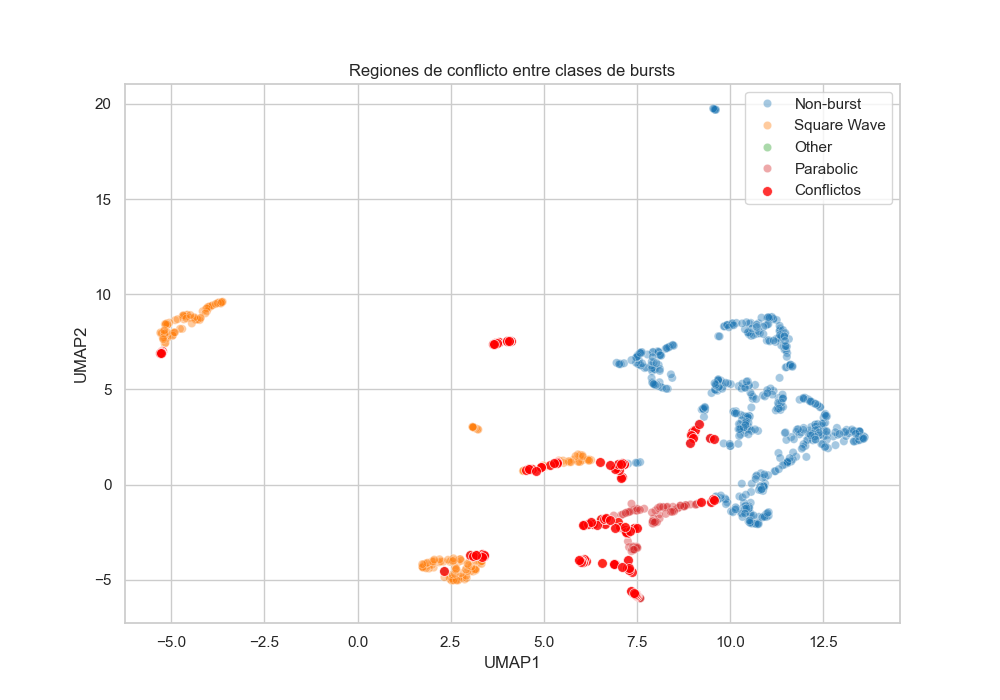

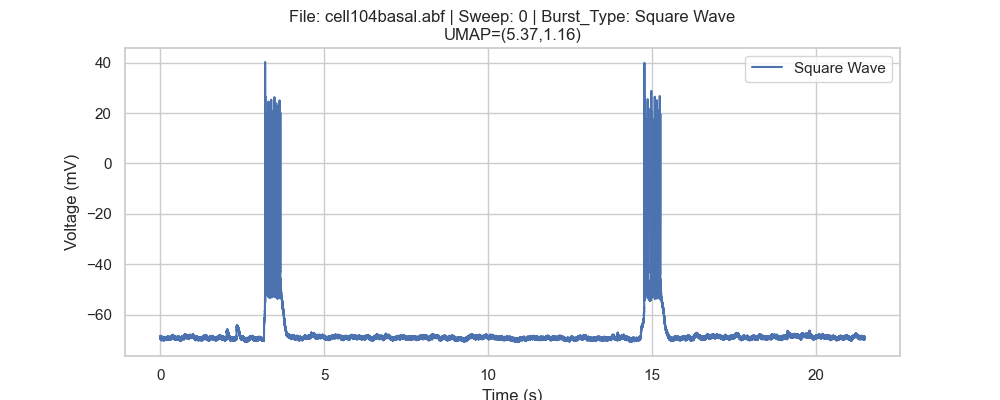

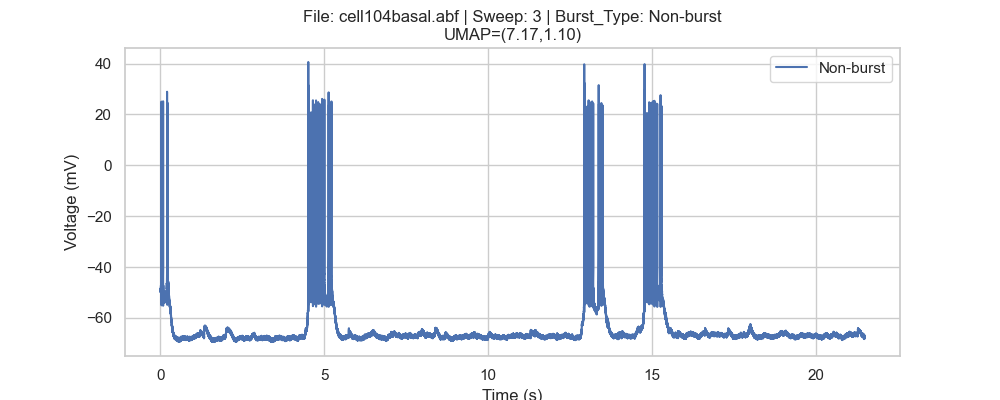

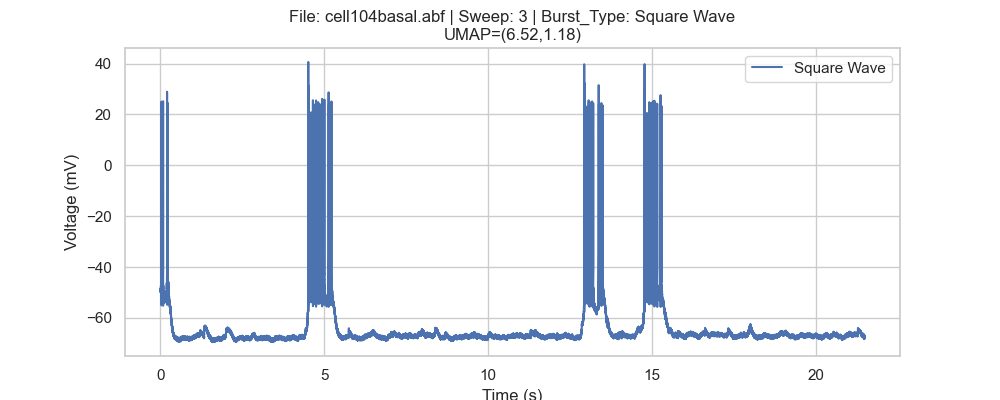


Archivo 'conflict_segments_with_umap.csv' guardado con métricas y coordenadas de los puntos conflictivos.


In [17]:
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors

# --- 1. Añadir índice para vincular con df_segments ---
df_umap["Index"] = df.index  # relaciona cada fila de UMAP con df_segments

# --- 2. Calcular centroides por tipo de burst ---
centroids = df_umap.groupby("Burst_Type")[["UMAP1", "UMAP2"]].mean()
dist_matrix = distance.cdist(centroids.values, centroids.values)
threshold = np.percentile(dist_matrix[dist_matrix > 0], 10)  # 10% de distancias más cortas

close_pairs = []
for i, type_i in enumerate(centroids.index):
    for j, type_j in enumerate(centroids.index):
        if j > i and dist_matrix[i, j] < threshold:
            close_pairs.append((type_i, type_j))

print("\nPares de tipos de bursts potencialmente solapados (por centroides):")
print(close_pairs)

# --- 3. Detectar puntos conflictivos usando vecinos cercanos ---
X_umap = df_umap[["UMAP1", "UMAP2"]].values
labels = df_umap["Burst_Type"].values

nbrs = NearestNeighbors(n_neighbors=8).fit(X_umap)
distances, indices = nbrs.kneighbors(X_umap)

conflict_indices = []
for i, neighbors in enumerate(indices):
    own_type = labels[i]
    neighbor_types = labels[neighbors]
    if np.any(neighbor_types != own_type):  # si hay vecinos de otra clase
        conflict_indices.append(df_umap.iloc[i]["Index"])

# Extraer métricas y coordenadas de los conflictos
conflicts_df = df_segments.iloc[conflict_indices]
conflict_umap_coords = df_umap.iloc[conflict_indices][["UMAP1", "UMAP2", "Burst_Type"]]

# --- FIX: eliminar columna duplicada antes de unir ---
conflict_umap_coords_nodup = conflict_umap_coords.drop(columns=["Burst_Type"])
conflict_data = conflicts_df.copy()
conflict_data = conflict_data.join(conflict_umap_coords_nodup.set_index(conflict_data.index))

print(f"\nNúmero de segmentos en regiones de conflicto: {len(conflict_data)}")
print(conflict_data.groupby("Burst_Type").size())

# --- 4. Graficar en UMAP resaltando los conflictos ---
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue="Burst_Type", alpha=0.4, palette="tab10")
sns.scatterplot(data=conflict_umap_coords, x="UMAP1", y="UMAP2",
                color="red", s=50, label="Conflictos", alpha=0.8)
plt.legend()
plt.title("Regiones de conflicto entre clases de bursts")
plt.show()

# --- 5. Graficar series temporales de los primeros N conflictos ---
N = 3  # número de conflictos a graficar
for idx in conflict_data.head(N).index:
    row = conflict_data.loc[idx]
    file_path = os.path.join(folder_path, row["File_Name"])
    abf = pyabf.ABF(file_path)
    abf.setSweep(row["Sweep"])
    time = abf.sweepX
    voltage = abf.sweepY

    # Graficar solo el segmento correspondiente al conflicto
    seg_start = time.min()
    seg_end = time.max()
    mask = (time >= seg_start) & (time <= seg_end)

    plt.figure(figsize=(10, 4))
    plt.plot(time[mask], voltage[mask], label=f"{row['Burst_Type']}")
    plt.title(f"File: {row['File_Name']} | Sweep: {row['Sweep']} | Burst_Type: {row['Burst_Type']}\nUMAP=({row['UMAP1']:.2f},{row['UMAP2']:.2f})")
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (mV)")
    plt.legend()
    plt.show()

# --- 6. Guardar resultados para inspección ---
conflict_data.to_csv("conflict_segments_with_umap.csv", index=False)
print("\nArchivo 'conflict_segments_with_umap.csv' guardado con métricas y coordenadas de los puntos conflictivos.")